<a href="https://colab.research.google.com/github/jeremysb1/xgboost/blob/main/decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

data = pd.read_csv('/content/drive/MyDrive/XGBoost/AB_NYC_2019.csv')

excluding_list = ['price', 'id', 'latitude', 'longitude', 'host_id', 'last_review', 'name', 'host_name']
low_card_categorical = ['neighbourhood_group', 'room_type']
high_card_categorical = ['neighbourhood']
continuous = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

target_mean = (data["price"] > data["price"].mean()).astype(int)
target_median = (data["price"] > data["price"].median()).astype(int)
target_multiclass = pd.qcut(data["price"], q=5, labels=False)
target_regression = data["price"]

categorical_onehot_encoding = OneHotEncoder(handle_unknown='ignore')
categorical_ord_encoding = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
numeric_passthrough = SimpleImputer(strategy="constant", fill_value=0)

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', categorical_ord_encoding, high_card_categorical),
     ('numeric', numeric_passthrough, continuous),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0)

A decision tree classifier:

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, cross_validate

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out = False,
    sparse_threshold=0.0)

model = DecisionTreeClassifier(random_state=0)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)])

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data,
                           y=target_median,
                           scoring=accuracy,
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])

print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit:  {fit_time:0.2f} secs pred: {score_time: 0.2f} secs")

0.761 (0.005) fit:  0.77 secs pred:  0.06 secs


Bagged tree-based classifier:

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = BaggingClassifier(estimator=DecisionTreeClassifier(),
                          n_estimators=300,
                          bootstrap=True,
                          max_samples=1.0,
                          max_features=1.0,
                          random_state=0)

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out = False,
    sparse_threshold=0.0)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)])

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data,
                           y=target_median,
                           scoring=accuracy,
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time: 0.2f} secs pred: {score_time:0.2f} secs")

0.809 (0.004) fit:  38.26 secs pred: 0.89 secs


Random Forests classifier:

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = RandomForestClassifier(n_estimators=300,
                               min_samples_leaf=3,
                               random_state=0)

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out = False,
    sparse_threshold=0.0)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)])

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data,
                           y=target_median,
                           scoring=accuracy,
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])

print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")

0.826 (0.004) fit: 12.61 secs pred: 0.65 secs


Extremely randomized trees classifier:

In [5]:
from sklearn.ensemble import ExtraTreesClassifier

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = ExtraTreesClassifier(n_estimators=300,
                             min_samples_leaf=3,
                             random_state=0)

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)])

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data,
                           y=target_median,
                           scoring=accuracy,
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")



0.823 (0.004) fit: 4.80 secs pred: 0.46 secs


## Gradient Boosting

Building a gradient boosting classifier:

In [10]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

class GradientBoosting():
    def __init__(self, learning_rate=0.1, n_estimators=10, **params):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.params = params
        self.trees = list()

    def sigmoid(self, x):
        x = np.clip(x, -100, 100)
        return 1 / (1 + np.exp(-x))

    def logit(self, x, eps=1e-6):
        xp = np.clip(x, eps, 1-eps)
        return np.log(xp / (1-xp))

    def gradient(self, y_true, y_pred):
        gradient = y_pred - y_true
        return gradient

    def fit(self, X, y):
        self.init = self.logit(np.mean(y))
        y_pred = self.init * np.ones((X.shape[0],))
        for k in range(self.n_estimators):
            gradient = self.gradient(self.logit(y), y_pred)
            tree = DecisionTreeRegressor(**self.params)
            tree.fit(X, -gradient)
            self.trees.append(tree)
            y_pred += self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        y_pred = self.init * np.ones((X.shape[0],))
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return self.sigmoid(y_pred)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return np.where(proba >= threshold, 1, 0)

Testing the gradient boosting class:

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(range(len(data)), test_size=0.2, random_state=0)

cls = GradientBoosting(n_estimators=300,
                       learning_rate=0.1,
                       max_depth=4,
                       min_samples_leaf=3,
                       random_state=0)

X = column_transform.fit_transform(data.iloc[train])
y = target_median[train]

cls.fit(X, y)

Xt = column_transform.transform(data.iloc[test])
yt = target_median[test]

preds = cls.predict(Xt)
score = accuracy_score(y_true=yt, y_pred=preds)
print(f"Accuracy: {score:0.5f}")

Accuracy: 0.82503


Plotting gradient boosting predicted probabilities:

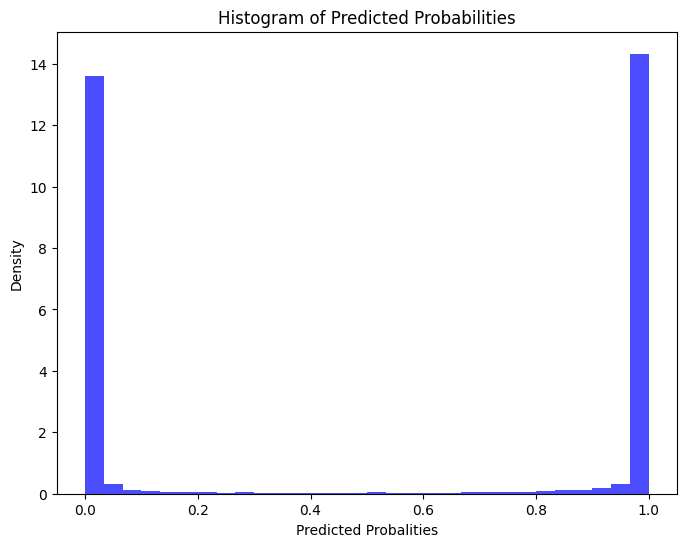

In [13]:
import matplotlib.pyplot as plt

proba = cls.predict_proba(Xt)
plt.figure(figsize=(8, 6))
plt.hist(proba, bins=30, density=True, color='blue', alpha=0.7)
plt.xlabel('Predicted Probalities')
plt.ylabel('Density')
plt.title('Histogram of Predicted Probabilities')
plt.show()